# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>Darknet Overview</b> 

___
# <b>Table of Content</b> <a id="toc_"></a>
* [<b>Darknet Traffic Overview</b>](#darknet)  
  * [Port Ranking](#portranking)  
  * [Darknet IPs Activity Pattern](#darknetpattern)  
  * [Dataset Statistics](#dataset)  
  * [Filter Definition](#darknetfilter)  
  * [Distinct IPs Seen Over 30 Days](#darknetips)  
  * [Last Day of Traffic](#lastday)  
    * [Some Notable GT Activity Patterns](#gtpattern)
  * [Ground Truth/Services Incidence](#gtserv)  
  

This notebook provides an overview of the collected darknet traffic. We go through the paper reporting the snippets that generate the statistics and the reported Figures. Namely, this report is related to Section 3 of the paper.

___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

In [ ]:
DEMONSTRATIVE = True

In [2]:
from config import *
from src.preprocess import *
import numpy as np
from src.corpus import get_services
from src.callbacks import *
from src.utils import *

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
# <b>Darknet Traffic Overview</b> <a name="darknet"></a>



Load 30 days of raw traffic. From 2021-03-02 to 2021-03-31. This is the full dataset we use in our experiments. 

Here we load an already slightly preprocessed dataset. In [Appendix 3](A03-darknet-checkpoint.ipynb) we provide the scripts for generating this intermediate dataset.

Each row of the dataset is a packet received from the darknet. The dataset columns are:

- `ts`. It is the timestamp of the packet arrival
- `ip`. It is the source IP address sending the packet
- `port`. It is the destination (darknet) port
- `proto`. Used protocol among TCP, UDP, ICMP, GRE, OTH (for others)
- `pp`. `port/proto` pairs used forthis load roughly 6 days only the language definition
- `class`. Ground truth class of the source IP

## Swap the lines below to read the full dataset - As it is now, it loads roughly 6 days only

In [4]:
if not DEMONSTRATIVE: darknet = load_raw_data('202103')
else: darknet = load_raw_data('2021030*')
    
darknet.head(3)

,ts,ip,port,proto,pck_len,pp
0,2021-03-08 05:28:55.907699,202.85.223.74,6378,tcp,60,6378/tcp
1,2021-03-08 05:28:55.937278,45.146.165.25,6653,tcp,60,6653/tcp
2,2021-03-08 05:28:55.998073,45.146.165.24,7394,tcp,60,7394/tcp


In [5]:
print(f'Traffic stats: ')
print(f'{darknet.ip.unique().shape[0]:,} distinct source IPs')
print(f"{darknet.pp.unique().shape[0]:,} destination 'port/protocol' pairs.")
print(f'{darknet.shape[0]:,} received packets')
print(f'Dataset shape: {darknet.shape}')

Traffic stats: 
176,948 distinct source IPs
70,159 destination 'port/protocol' pairs.
14,384,904 received packets
Dataset shape: (14384904, 6)


### <b>Port Ranking</b> <a name="portranking"></a>  


Next we characterize the darknet. We focus on the port popularity in terms of received packets. 

In [6]:
# Get the port frequency from 30 days of traffic
top14 = darknet.value_counts('port').reset_index().rename(columns={0:'pkts'})
# Compute the ECDF(packets)
pkts = top14.sort_values('pkts', ascending=False)
pkts.pkts = np.cumsum(pkts.pkts)/np.sum(pkts.pkts)
# Zoom-in: Get the top-14 ports within 30 days
top = top14.sort_values('pkts', ascending=False)
top.pkts = np.cumsum(top.pkts)/np.sum(top14.pkts)
top = top.iloc[:14]

<Figure size 640x480 with 0 Axes>

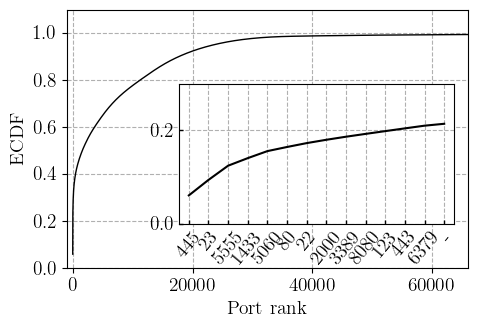

In [7]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: portRanking(plt, pkts, top),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/top20.pdf')
plot.show()

### <b>Darknet IPs Activity Pattern</b> <a name="darknetpattern"></a>  


To provide the big picture, we visualize some IP addresses activity pattern.

We extract a time window shorter than 30 days and downsample the received traffic (modulo 3) to make the patterns more evident. Then a scatterplot is generated. Here, each dot is a packet sent by an IP $y$ at the istant $x$.

In [8]:
# Extract a 9 days window to make the IPs patterns more evident
tday_ = darknet[darknet.ts<='2021-3-11 23:28:56.952226'][['ts', 'ip']]
tday = pd.DataFrame(tday_, columns=['ts', 'ip'])
# Manage timestamps and sort them
tday.index = pd.DatetimeIndex(tday.ts)
tday = tday.sort_index()
tday = tday.drop(columns=['ts'])
# Tokenize IPs. From string to integer number
ydict = {v: k for k,v in enumerate(tday.ip.unique())}
tday['tkn'] = tday.ip.apply(lambda x: ydict[x])
# mod3 downsampling for reducing the image weight
resampled_idx = [x for x in range(tday.shape[0]) if x%3 == 0]
tday = tday.iloc[resampled_idx]

<Figure size 640x480 with 0 Axes>

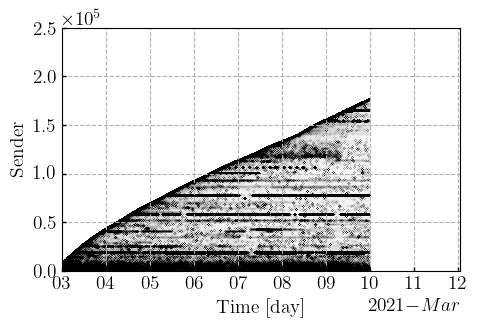

In [9]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: darknetPatterns(plt, tday),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/density.png')
plot.show()

### <b>Dataset Statistics</b> <a name="dataset"></a>  

We improve the knowledge about the dataset by providing some statistics for both 30 days of darknet traffic and 1 day. In this second case the considered day is the 30^{th} of the full dataset.

In [10]:
df30 = darknet.copy()
df1 = load_raw_data('20210331')

In [11]:
# Number of IPs
ip1 = df1.ip.unique().shape[0]
ip30 = df30.ip.unique().shape[0]
# Number of packets
pkts1 = df1.shape[0]
pkts30 = df30.shape[0]
# Number of ports
port1 = df1.port.unique().shape[0]
port30 = df30.port.unique().shape[0]
# Top-3 ports
top3_1 = df1.value_counts('pp').index[:3]
top3_30 = df30.value_counts('pp').index[:3]
# Packets of top-3 ports
top3pkts1 = (df1.value_counts('pp')/df1.shape[0]*100).values[:3]
top3pkts30 = (df30.value_counts('pp')/df30.shape[0]*100).values[:3]

Get the IPs targeting the top-3 ports of the considered datasets

In [12]:
df1[df1.pp.isin(top3_1)].groupby('pp').agg({'ip':lambda x: len(set(x))})

,ip
pp,
23/tcp,16102
445/tcp,4274
5555/tcp,1522


In [13]:
df30[df30.pp.isin(top3_30)].groupby('pp').agg({'ip':lambda x: len(set(x))})

,ip
pp,
23/tcp,68435
445/tcp,23054
5555/tcp,7113


In [14]:
# Collect statistics
print('Date ($YYYY-MM-DD$):')
print(f'\tLast Day: 2021-03-31')
print(f'\tFull Dataset: [2021-03-02, 2021-03-31]')

print('Sources:')
print(f'\tLast Day: {ip1}')
print(f'\tFull Dataset: {ip30}')

print('Packets:')
print(f'\tLast Day: {pkts1}')
print(f'\tFull Dataset: {pkts30}')

print('Ports:')
print(f'\tLast Day: {port1}')
print(f'\tFull Dataset: {port30}')

print('Top-3 ports (\% of traffic):')
print(f'\tLast Day: {top3_1[0]} ({round(top3pkts1[0], 2)}\%), {top3_1[1]} ({round(top3pkts1[1], 2)}\%),{top3_1[2]} ({round(top3pkts1[2], 2)}\%)')
print(f'\tFull Dataset: {top3_30[0]} ({round(top3pkts30[0], 2)}\%), {top3_30[1]} ({round(top3pkts30[1], 2)}\%),{top3_30[2]} ({round(top3pkts30[2], 2)}\%)')

Date ($YYYY-MM-DD$):
	Last Day: 2021-03-31
	Full Dataset: [2021-03-02, 2021-03-31]
Sources:
	Last Day: 43118
	Full Dataset: 176948
Packets:
	Last Day: 3461220
	Full Dataset: 14384904
Ports:
	Last Day: 19677
	Full Dataset: 127632
Top-3 ports (\% of traffic):
	Last Day: 445/tcp (8.33\%), 5555/tcp (8.15\%),23/tcp (3.54\%)
	Full Dataset: 445/tcp (6.02\%), 23/tcp (3.32\%),5555/tcp (3.05\%)


### <b>Filter Definition</b> <a name="darknetfilter"></a>  


Given the large amount of packets received in 30 days, a filter is needed to improve visualization and reduce noisy traffic (e.g., senders that send only a couple of packets in a month are not interesting for this analysis). 

We design our filter with respect to the monthly packets sent by each IP. We evaluate the distribution of this amount and set the filtering threshold to 10 packets. In this way, we keep the IP addresses sending _at least 10 packets over a month_.

In [15]:
# Count the packets per IP over a month
cdf = darknet.value_counts('ip').reset_index().drop(columns=['ip'])\
             .rename(columns={0:'pkts'}).value_counts('pkts')
# Get the ECDF
cdf = cdf.sort_index()
cdf = np.cumsum(cdf)/np.sum(cdf)

<Figure size 640x480 with 0 Axes>

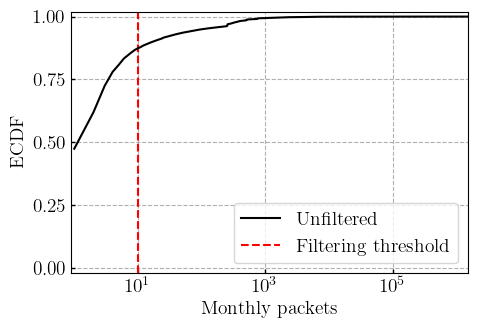

In [16]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: filterECDF(plt, cdf),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/pkts_cdf.pdf')
plot.show()

### <b>Distinct IPs Seen Over 30 Days</b> <a name="darknetips"></a>  


After having filtering the dataset, we investigate the impact of the filter impact on the full 30 days dataset. Thus, we compare the number of distinct IPs seen on each day over the observation period between the filtered and unfiltered dataset.

In [17]:
dnet = darknet.copy()
# Count the number of packet per IPs for defining the filter
ips = darknet.value_counts('ip')
# Filter: keep IPs sending at least 10 packets
ips_f = set(ips[ips>=10].index)
# Apply the filter
dnet_f = dnet[dnet.ip.isin(ips_f)]

# Get the number of distinc IPs per day in both the filtered
# and unfiltered case
dnet = get_ip_set_by_day(dnet)
dnet_f = get_ip_set_by_day(dnet_f)
# Make the DataFrame for the fastplot callback
cdf = pd.DataFrame(get_ips_ecdf(dnet))[1].values
cdf_f = pd.DataFrame(get_ips_ecdf(dnet_f))[1].values

<Figure size 640x480 with 0 Axes>

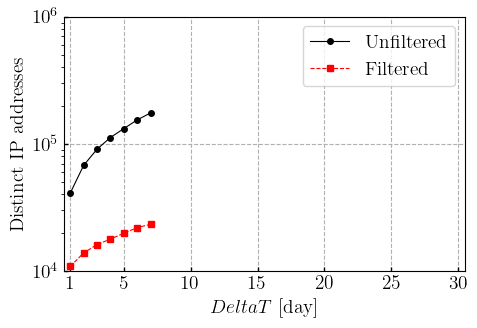

In [18]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: filterCoverage(plt, cdf, cdf_f),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/daily_ips_v2.pdf')
plot.show()

___
# <b>Last Day of Traffic</b> <a name="lastday"></a>



We now show characteristics of the last day of darknet traffic used in some experiments. We report in [Appendix 3](A03-darknet-checkpoint.ipynb) the scripts for generating this sample. Then we apply the filter and provide some statistics on the ground truth. Finally we extract some notable activity patterns.

In [19]:
raw_data = load_raw_data('20210331')
daily = filter_data(raw_data, '20210331')

In [20]:
# Load the ground truth
gt = pd.read_csv(GT).drop(columns=['Unnamed: 0'])
ips = daily.ip.unique()
# Get the lookup dataframe to retrieve
# the ground truth class of the last day senders
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown').replace({ 'criminalip':'unknown', 
                'adscore':'unknown', 'quadmetrics':'unknown', 
                'esrg_stanford':'unknown', 'netscout':'unknown'})
lookup = lookup.rename(columns={'gt':'class'})
print(lookup.shape)
lookup.head(3)

(22399, 2)


,ip,class
0,201.166.132.114,unknown
1,172.245.10.231,unknown
2,119.237.180.88,unknown


Then we apply the filter keeping the IPs sending at least 10 packets over 30 days. Then we extract some statistics about the ground truth

In [21]:
daily = daily.merge(lookup, on='ip', how='left')
# Collect the statistics
stats = [get_last_day_stats(daily, x) for x in daily['class'].unique()]
pd.DataFrame(stats, columns=['Source', 'Senders', 'Packets', 
                             'Ports', 'Top-5 Ports (% Traffic)'])\
  .sort_values('Senders', ascending=False)

,Source,Senders,Packets,Ports,Top-5 Ports (% Traffic)
0,unknown,14272,2971687,10714,"445/tcp(9.4%), 5555/tcp(9.4%), 1433/tcp(1.8%),..."
1,mirai,7351,88192,75,"23/tcp(89.6%), 2323/tcp(3.9%), 5555/tcp(1.7%),..."
2,censys,336,233004,11123,"5060/tcp(3.4%), 2000/tcp(2.9%), 443/tcp(0.4%),..."
7,stretchoid,104,57144,91,"22/tcp(3.5%), 443/tcp(3.5%), 9200/tcp(2.7%), 2..."
6,internet-census,103,9396,233,"5060/tcp(10.4%), 161/udp(9.8%), 2000/tcp(7.7%)..."
8,binaryedge,101,7646,21,"15/tcp(10.0%), 3000/tcp(9.7%), 4222/tcp(6.7%),..."
5,sharashka,50,5436,485,"5986/tcp(0.5%), 2103/tcp(0.5%), 2052/tcp(0.4%)..."
3,ipip,49,17342,41,"5060/tcp(41.5%), -/icmp(11.0%), 8000/tcp(2.4%)..."
4,shodan,23,13566,363,"2000/tcp(0.7%), 443/tcp(0.7%), 2087/tcp(0.7%),..."
9,engin-umich,10,506,1,53/udp(100.0%)


### <b>Some Notable GT Activity Patterns</b> <a name="gtpattern"></a> 



By applying the same technique as before, we extract the activity patterns plot for two ground truth classes: Engin-Umich and Stretchoid.


In [22]:
if not 'class' in darknet:
    darknet = darknet.merge(lookup, on='ip', how='left')
# Extract the stretchoid traces from the full darknet ones
stretchoid = darknet[darknet['class'] == 'stretchoid']
stretchoid.index = pd.DatetimeIndex(stretchoid.ts)
stretchoid = stretchoid.sort_index()
# Tokenize Stretchoid IPs
ydict = {v: k for k,v in enumerate(stretchoid.ip.unique())}
stretchoid['tkn'] = stretchoid.ip.apply(lambda x: ydict[x])
# Build the activity patterns timeseries
stretchoid = stretchoid[['ip', 'tkn']]
stretchoid.head()

,ip,tkn
ts,,
2021-03-02 21:36:32.355505,192.241.227.104,0
2021-03-02 21:36:33.967158,192.241.227.104,0
2021-03-02 21:36:34.309916,192.241.227.104,0
2021-03-02 21:36:34.452219,192.241.227.104,0
2021-03-02 21:36:39.067579,192.241.227.104,0


<Figure size 640x480 with 0 Axes>

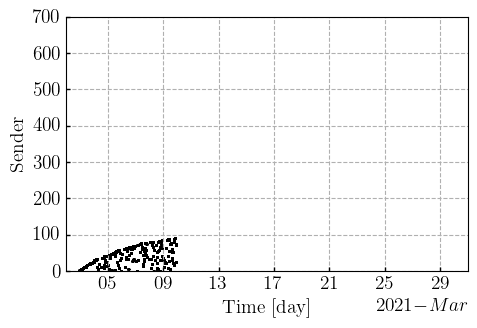

In [23]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: stretchoidPattern(plt, stretchoid),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/stretchoid_pattern.png')
plot.show()

In [24]:
# Extract the engin-umich traces from the full darknet ones
en_um = darknet[darknet['class'] == 'engin-umich']
en_um.index = pd.DatetimeIndex(en_um.ts)
# Tokenize Stretchoid IPs
ydict = {v: k for k,v in enumerate(en_um.ip.unique())}
en_um['tkn'] = en_um.ip.apply(lambda x: ydict[x])
# Build the activity patterns timeseries
en_um = en_um[['ip', 'tkn']]
en_um.head()

,ip,tkn
ts,,
2021-03-03 17:04:59.420514,141.212.123.185,0
2021-03-04 16:17:57.971027,141.212.123.185,0
2021-03-04 20:05:42.389669,141.212.123.185,0
2021-03-04 20:06:28.864292,141.212.123.185,0
2021-03-04 20:06:38.672277,141.212.123.185,0


<Figure size 640x480 with 0 Axes>

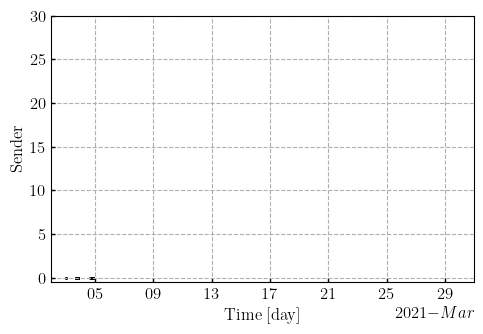

In [25]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: enginumichPattern(plt, en_um),
                      cycler=cc, figsize=(5, 3.5), fontsize=12, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/engin_umich_pattern.png')
plot.show()

### <b>Ground Truth/Services Incidence</b> <a name="gtserv"></a> 



Generate an heatmap indicating the fraction of GT class packets sent to ports used by general-purpose services.


In [26]:
raw_data = load_raw_data('20210331')
daily = filter_data(raw_data, '20210331')
# Get the class of services
daily['serv'] = daily.pp.apply(get_services)
# Add a ones column for packets sum
daily['pkts'] = 1
daily = daily.merge(lookup, on='ip', how='left')
daily = daily.replace({'unk_usr':'others', 'unk_sys':'others', 
                       'unk_eph':'others', 'proxy':'others'})
daily.head(3)

,ts,ip,port,proto,pck_len,pp,serv,pkts,class
0,2021-03-30 22:29:08.691001,201.166.132.114,1433,tcp,66,1433/tcp,dbs,1,unknown
1,2021-03-30 22:29:08.691010,201.166.132.114,1433,tcp,66,1433/tcp,dbs,1,unknown
2,2021-03-30 22:29:08.811067,172.245.10.231,3699,tcp,60,3699/tcp,others,1,unknown


In [27]:
pivot = daily.pivot_table(values='pkts', index='class', columns='serv', 
                       aggfunc='sum')\
          .reindex(columns=daily.serv.unique())\
          .fillna(.0)
pivot = pivot.divide(pivot.sum(axis=1), axis='rows').round(2).T

<Figure size 640x480 with 0 Axes>

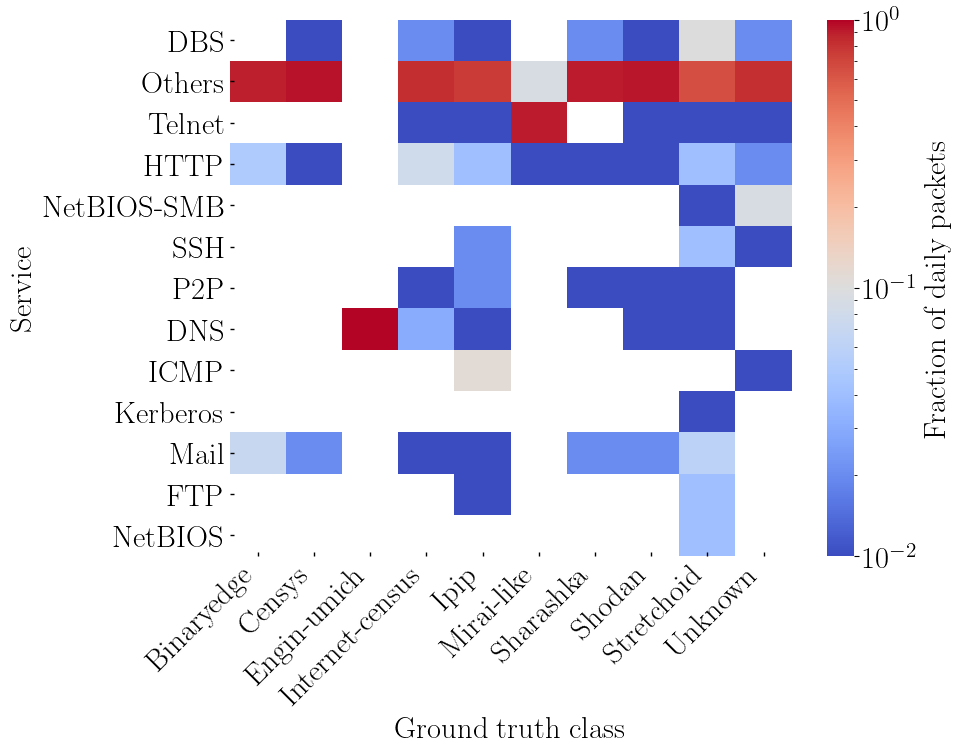

In [28]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: ground_truth_heatmap(plt, pivot),
                      figsize=(10, 8), fontsize=22, xticks_rotate=45, style='latex')
if not DEMONSTRATIVE:
    plot.savefig(f'reports/figures/heatmap_gt_serv.pdf')
plot.show()